[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nipunbatra/ml-teaching/blob/master/notebooks/autodiff.ipynb)


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Set random seed for reproducibility
torch.manual_seed(0)

# Torch version
torch.__version__

'2.6.0'

In [25]:
### Derviatives using numerical differentiation

def f(x):
    return 3 * x ** 2 + 2 * x + 1

def numerical_derivative_single_side(f, x, h=0.001):
    x = float(x)
    return (f(x + h) - f(x)) / h

def numerical_derivative_double_side(f, x, h=0.001):
    x = float(x)
    return (f(x + h) - f(x - h)) / (2 * h)

x = torch.tensor(2.0, requires_grad=False)
print(f'f\'(2) = {numerical_derivative_single_side(f, x, 0.00001)}')
print(f'f\'(2) = {numerical_derivative_double_side(f, x, 0.00001)}')

f'(2) = 14.00003000000538
f'(2) = 14.000000000002897


### Issue 1: Numerical precision and stability

In [33]:
hs = [10**(-i) for i in range(1, 21)]  # 1e-1 ... 1e-20

print("h".ljust(10), "f'(2)")
print("-" * 25)
for h in hs[::-1]:  # from small to large
    val = numerical_derivative_double_side(f, 2.0, h)
    print(f"{h:>10.0e}  {val:8.15f}")

h          f'(2)
-------------------------
     1e-20  0.000000000000000
     1e-19  0.000000000000000
     1e-18  0.000000000000000
     1e-17  0.000000000000000
     1e-16  0.000000000000000
     1e-15  14.210854715202002
     1e-14  14.210854715202004
     1e-13  13.997691894473974
     1e-12  14.001244608152774
     1e-11  13.999823522681254
     1e-10  14.000001158365194
     1e-09  14.000001158365194
     1e-08  13.999999737279722
     1e-07  13.999999985969680
     1e-06  14.000000001956892
     1e-05  14.000000000002897
     1e-04  14.000000000020663
     1e-03  13.999999999997570
     1e-02  13.999999999999702
     1e-01  14.000000000000004


### Issue 2: Expensive for high dimensions (number of forward passes $\propto$ number of parameters)

In [35]:
def f(theta_0, theta_1, theta_2, theta_3, theta_4):
    return theta_0 + 2 * theta_1 + 3 * theta_2 + 4 * theta_3 + 5 * theta_4



thetas = [torch.tensor(1.0), torch.tensor(2.0), torch.tensor(3.0),
          torch.tensor(4.0), torch.tensor(5.0)]

names = ['theta_0','theta_1','theta_2','theta_3','theta_4']


f(*thetas)

tensor(55.)

In [38]:
h = 0.0001
calls = 0
for i, name in enumerate(names):
    # Copy all current parameter values
    t0, t1, t2, t3, t4 = thetas
    
    # Define f_i as a function of just one parameter changing
    if i == 0: f_i = lambda t: f(t, t1, t2, t3, t4)
    if i == 1: f_i = lambda t: f(t0, t, t2, t3, t4)
    if i == 2: f_i = lambda t: f(t0, t1, t, t3, t4)
    if i == 3: f_i = lambda t: f(t0, t1, t2, t, t4)
    if i == 4: f_i = lambda t: f(t0, t1, t2, t3, t)

    g = numerical_derivative_double_side(f_i, thetas[i], h)
    print(f'df/d{name} = {g:.4f}')
    
    calls += 2  # two calls to f_i per derivative

print(f'Number of calls to f: {calls}')



df/dtheta_0 = 0.9918
df/dtheta_1 = 1.9836
df/dtheta_2 = 3.0136
df/dtheta_3 = 4.0054
df/dtheta_4 = 4.9973
Number of calls to f: 10


### Practical example to illistrate autodiff

In [40]:
theta_0 = torch.tensor(1.0, requires_grad=True)
theta_1 = torch.tensor(1.0, requires_grad=True)
theta_2 = torch.tensor(2.0, requires_grad=True)

x1 = torch.tensor(1.0)
x2 = torch.tensor(2.0)

f1 = theta_1*x1
f2 = theta_2*x2

f3 = f1 + f2

f4 = f3 + theta_0

f5 = f4*-1

f6 = torch.exp(f5)

f7 = 1 + f6

f8 = 1/f7

f9 = torch.log(f8)

L = f9*-1

all_nodes = {"theta_0": theta_0, "theta_1": theta_1, "theta_2": theta_2,  
             "f1": f1, "f2": f2, "f3": f3, "f4": f4, "f5": f5, "f6": f6, "f7": f7, "f8": f8, "f9": f9, "L": L}

# Retain grad for all nodes
for node in all_nodes.values():
    node.retain_grad()

In [41]:
# Print out the function evaluation for all nodes along with name of the node
for name, node in all_nodes.items():
    print(f"{name}: {node.item()}")

theta_0: 1.0
theta_1: 1.0
theta_2: 2.0
f1: 1.0
f2: 4.0
f3: 5.0
f4: 6.0
f5: -6.0
f6: 0.0024787522852420807
f7: 1.0024787187576294
f8: 0.9975274205207825
f9: -0.0024756414350122213
L: 0.0024756414350122213


In [42]:
L.backward()

# Print out the gradient for all nodes along with name of the node
for name, node in all_nodes.items():
    print(f"{name}: {node.grad.item()}")


theta_0: -0.00247262348420918
theta_1: -0.00247262348420918
theta_2: -0.00494524696841836
f1: -0.00247262348420918
f2: -0.00247262348420918
f3: -0.00247262348420918
f4: -0.00247262348420918
f5: 0.00247262348420918
f6: 0.9975274801254272
f7: 0.9975274801254272
f8: -1.0024787187576294
f9: -1.0
L: 1.0


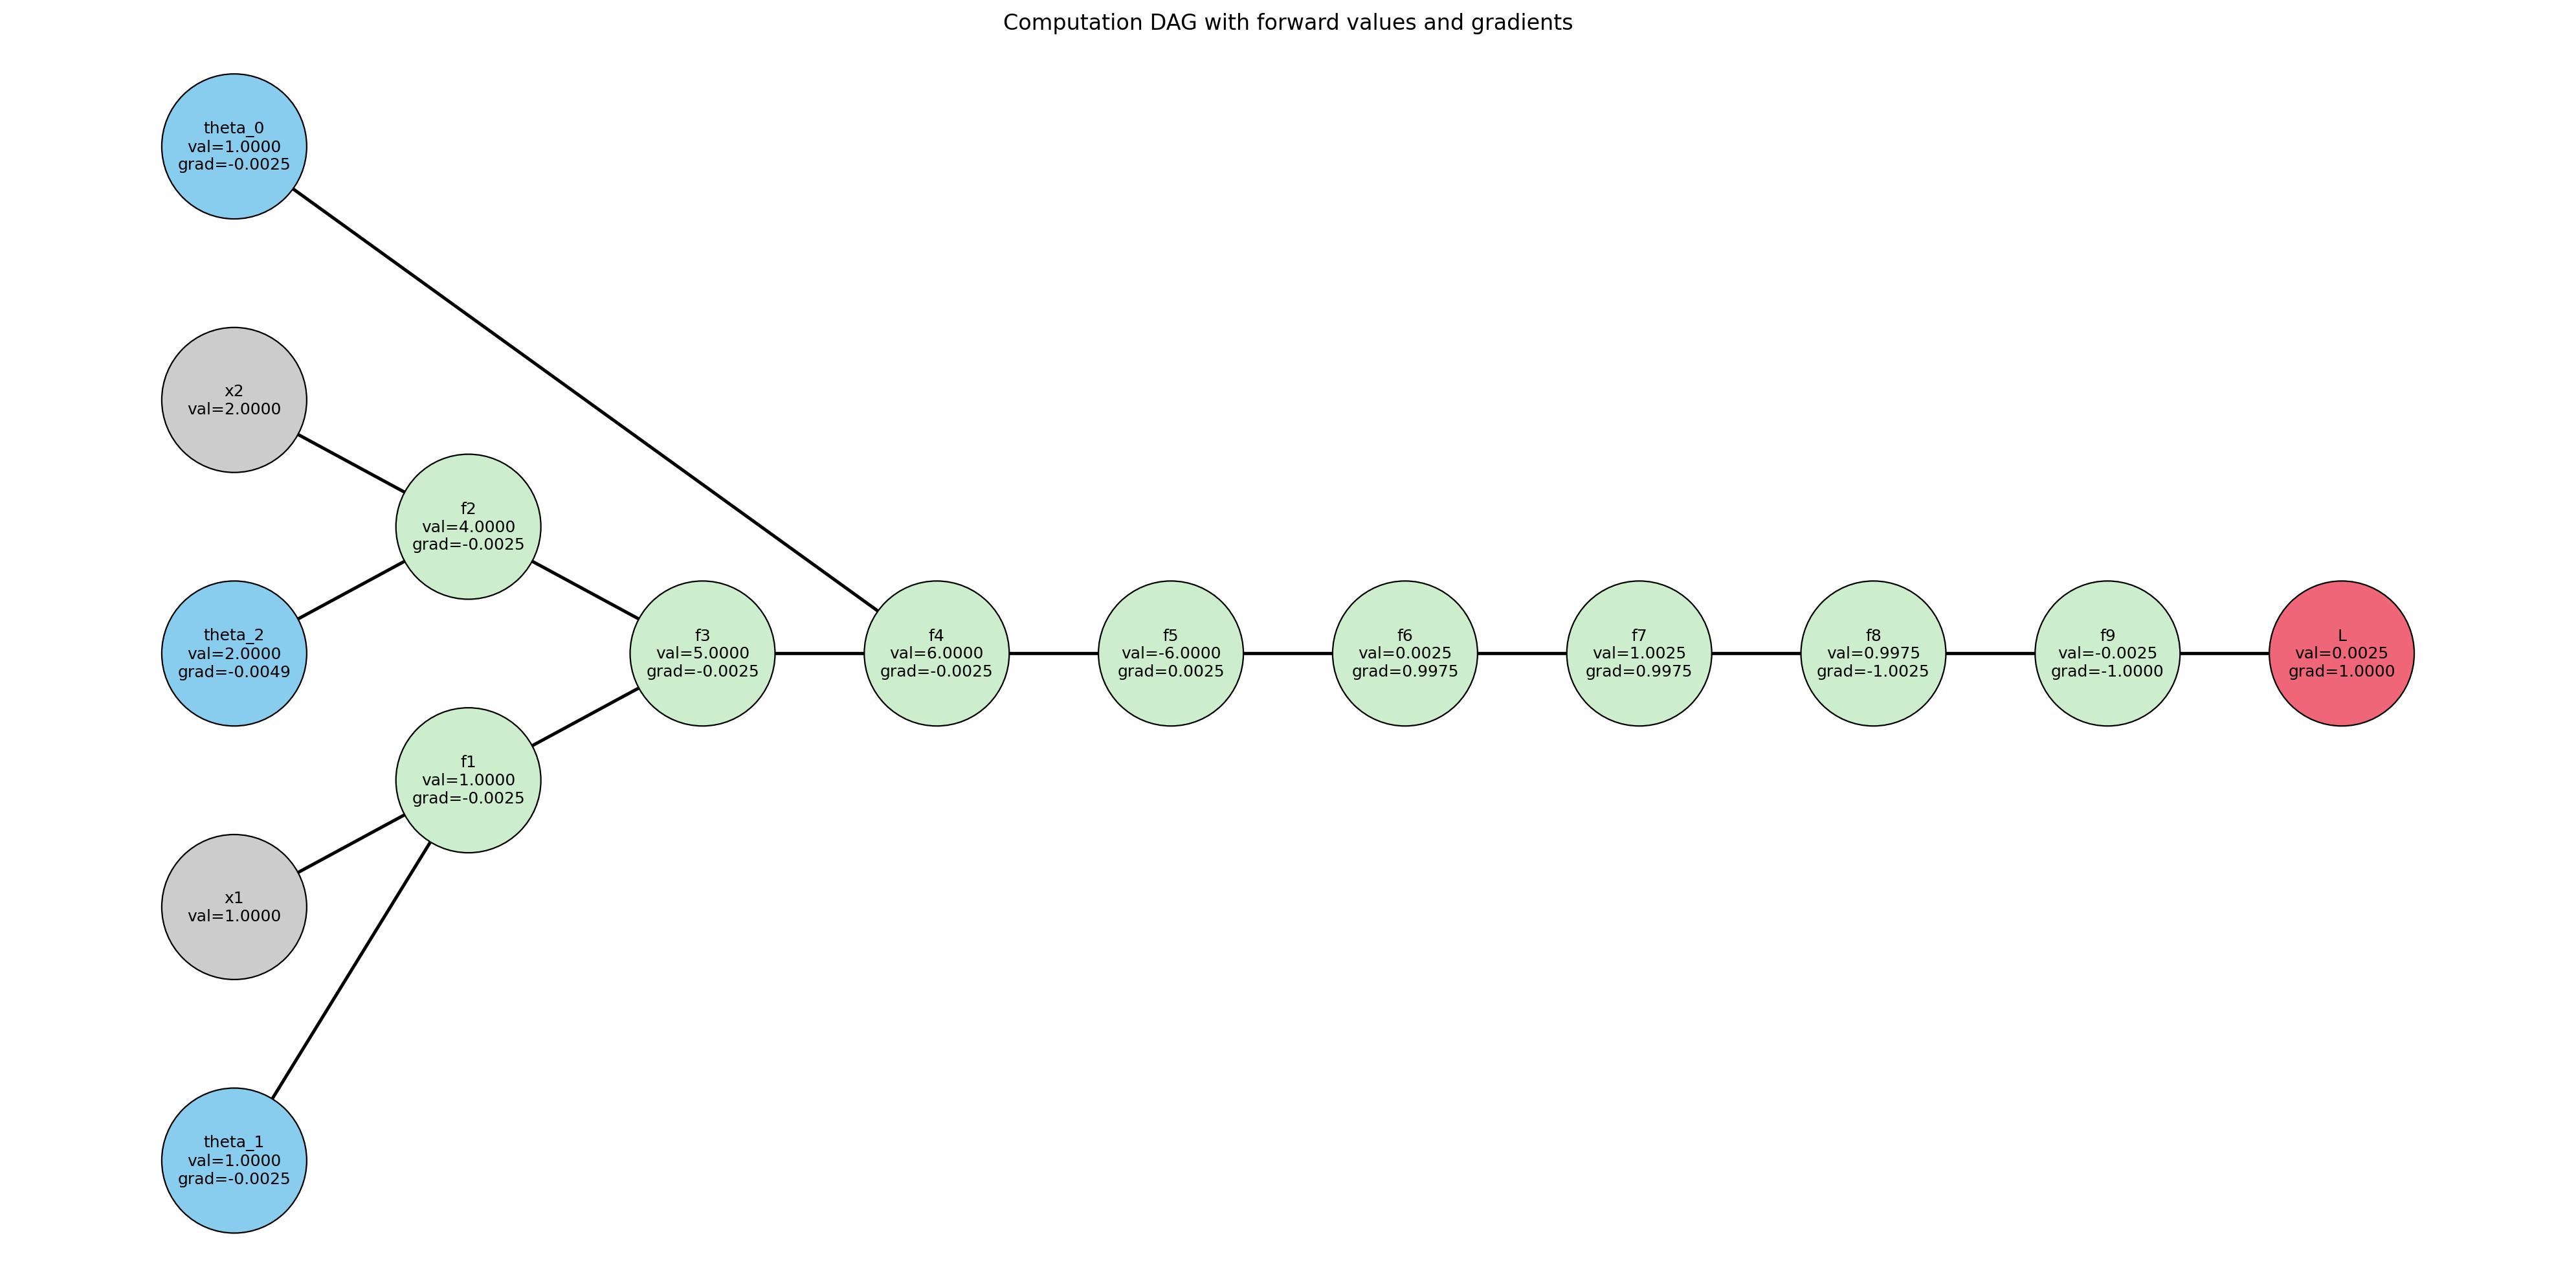

In [48]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_computation_dag(all_nodes, x1, x2):
    # ----- nodes & layers -----
    inputs     = ['x1', 'x2']
    params     = ['theta_0', 'theta_1', 'theta_2']
    interms    = ['f1','f2','f3','f4','f5','f6','f7','f8','f9']
    loss_node  = ['L']

    layers = {
        0: ['theta_1','x1','theta_2','x2','theta_0'],
        1: ['f1','f2'],
        2: ['f3'],
        3: ['f4'],
        4: ['f5'],
        5: ['f6'],
        6: ['f7'],
        7: ['f8'],
        8: ['f9'],
        9: ['L'],
    }

    # ----- edges (producer -> consumer) -----
    edges = [
        ('theta_1','f1'), ('x1','f1'),
        ('theta_2','f2'), ('x2','f2'),
        ('f1','f3'), ('f2','f3'),
        ('f3','f4'), ('theta_0','f4'),
        ('f4','f5'),
        ('f5','f6'),
        ('f6','f7'),
        ('f7','f8'),
        ('f8','f9'),
        ('f9','L'),
    ]

    # Build graph
    G = nx.DiGraph()
    G.add_nodes_from(inputs + params + interms + loss_node)
    G.add_edges_from(edges)

    # Positions: grid by layers
    pos = {}
    for lx, nodes in layers.items():
        n = len(nodes)
        ys = list(range(n))
        # center vertically
        ys = [y - (n-1)/2 for y in ys]
        for i, name in enumerate(nodes):
            pos[name] = (lx, ys[i])

    # Node colors
    color_map = {}
    for n in G.nodes:
        if n in params:       color_map[n] = '#88CCEE'   # params
        elif n in inputs:     color_map[n] = '#CCCCCC'   # inputs
        elif n in loss_node:  color_map[n] = '#EE6677'   # loss
        else:                 color_map[n] = '#CCEECC'   # interms
    node_colors = [color_map[n] for n in G.nodes]

    # Labels with value and grad (if available)
    def node_val(name):
        if name in ['x1','x2']:
            return float(x1.item()) if name=='x1' else float(x2.item())
        return float(all_nodes[name].item())

    def node_grad(name):
        if name in ['x1','x2']: return None
        g = all_nodes[name].grad
        return None if g is None else float(g.item())

    labels = {}
    for n in G.nodes:
        val = node_val(n)
        g   = node_grad(n)
        if g is None:
            labels[n] = f"{n}\nval={val:.4f}"
        else:
            labels[n] = f"{n}\nval={val:.4f}\ngrad={g:.4f}"

    # Draw
    plt.figure(figsize=(20,10))
    nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='-|>', arrowsize=16, width=1.8)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=6500, edgecolors='black', linewidths=0.8)
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)

    plt.axis('off')
    plt.title("Computation DAG with forward values and gradients")
    plt.tight_layout()
    
plot_computation_dag(all_nodes, x1, x2)

In [6]:
torch.exp(f5)*0.9975

tensor(0.0025, grad_fn=<MulBackward0>)

### Micrograd demo

https://github.com/karpathy/micrograd/blob/master/micrograd/engine.py

In [20]:
### Example to illustrate accumulation of gradients

theta = torch.tensor(1.0, requires_grad=True)

x1 = torch.tensor(1.0)
x2 = torch.tensor(2.0)

L1 = theta*x1
L2 = theta*x2

L = L1 + L2
L.backward()

In [22]:
theta.grad

tensor(3.)

### Why do we need to use torch.no_grad() in the test phase?
### Why do we need to zero out the gradients in the training phase after each update?

```py
model = SimpleModel()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Dummy data
inputs = torch.randn((100, 10))
targets = torch.randn((100, 1))

# Training loop
for epoch in range(100):
    # Forward pass
    outputs = model(inputs)
    
    # Compute the loss
    loss = criterion(outputs, targets)
    
    # Zero the gradients
    optimizer.zero_grad()
    
    # Backward pass
    loss.backward()
    
    # Update the weights
    optimizer.step()

    # Print the loss every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
```